In [137]:
# Standard library
from pathlib import Path

# 3rth party
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Loading

To start let's load the data. We're going to use the FEI database again. Now let's do it again but aiming at using the labels for classification.

In [139]:
IMG_FOLDER = Path("/home/jpsrocha/Documents/Data/FEI_faces_norm/")
IMG_FILES = sorted(IMG_FOLDER.glob("*jpg"))
FIG_FOLDER = Path("../res/ML_Exercises/GB500/exercise_list_3/report/figures/")

Y = np.array([1 if path.name.split(".")[0][-1] == "b" else 0 for path in IMG_FILES])

In [4]:
imgs = []

for img in IMG_FILES:
    imgs.append(plt.imread(img).reshape(1, -1))  # Loading and reshaping

X = np.vstack(imgs)

del imgs  # Deleting images to save space

# Playing with KPCA

Let's quickly play with the KPCA to see how it reacts to different hyperparameters on the first PC's.

In [141]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

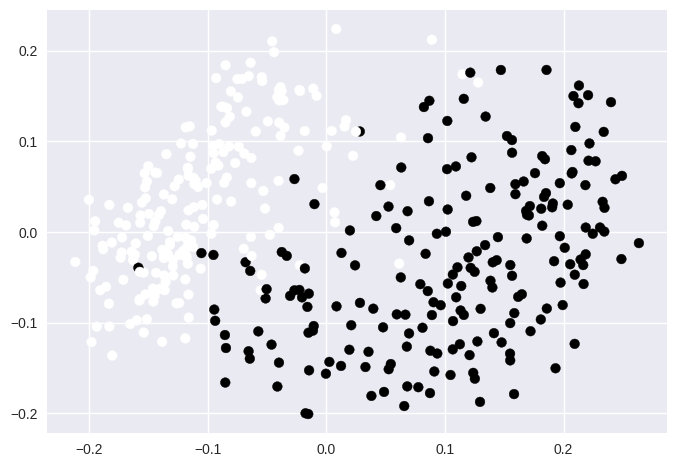

In [198]:
plt.style.use("seaborn-v0_8")


kpca = KernelPCA(n_components=100, kernel="cosine")


X_pca = kpca.fit_transform(X)

x, y = X_pca[:, [0, 1]].T

plt.scatter(x, y, c=Y)

# (a) Linear SVM + KPCA

Before going for the K-Fold cross validation, let's define a function to help instantiate the same model for each run.

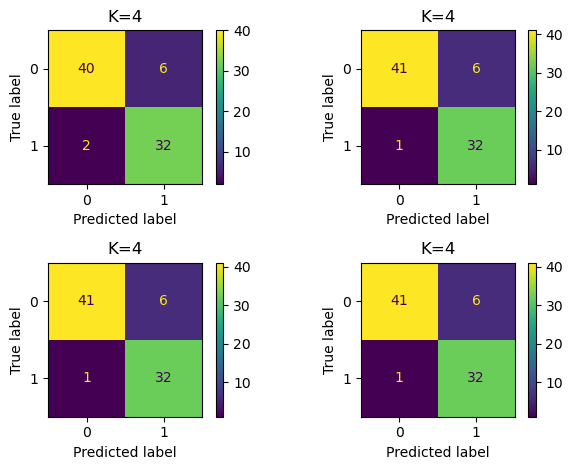

In [207]:
plt.style.use("default")

# Function to make it cleaner to instantiate new model
def model_a():
    return  make_pipeline(
                KernelPCA(n_components=150, kernel="cosine"),
                SVC(kernel="linear")
            )

# Function to reuse cross validation

def kf_classifier_cross_val(model_factory, X, Y, k=4, plot_filename=None) -> tuple[float, float]:
    """Function to make cross validation reutilizable"""

    # Starting auxiliar variables
    kf = KFold(k, random_state=42, shuffle=True)
    models = []
    accuracies = []

    # Training on each fold
    for i, (train_i, test_i) in enumerate(kf.split(X, Y), start=1):
        
        models.append(
            model_factory().fit(X[train_i], Y[train_i])
        )
        
        accuracies.append(models[-1].score(X[test_i], Y[test_i]))

    # Plot if necessary
    if plot_filename:
        
        fig, axes = plt.subplots(nrows=2, ncols=2)
        X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2)


        for model, ax in zip(models, axes.ravel()):
            ConfusionMatrixDisplay(confusion_matrix(model.predict(X_test), Y_test)).plot(ax=ax)
            ax.set_title(f"K={i}")

        plt.tight_layout()
        plt.savefig(FIG_FOLDER / plot_filename, dpi=100)
        plt.show()
        
        
    return np.mean(accuracies).item(), np.std(accuracies).item(), accuracies


mu, std, acc_a = kf_classifier_cross_val(model_a, X, Y, plot_filename="q1_a.png")

In [157]:
mu, std

(0.9425, 0.028613807855648963)

# (b) Kernel SVM + PCA

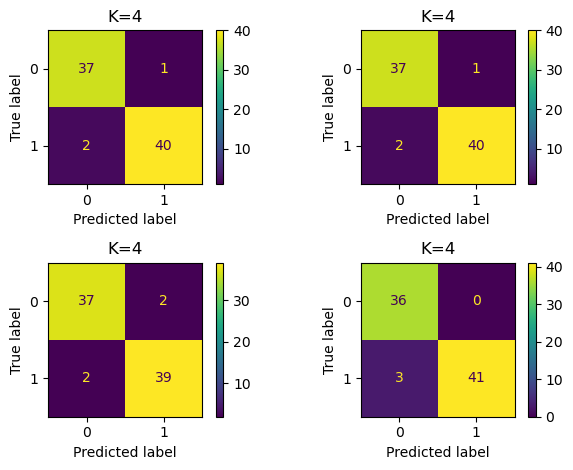

In [208]:

def model_b():
    return  make_pipeline(
                PCA(n_components=150),
                SVC(kernel="sigmoid")
            )

mu_b, std_b, acc_b = kf_classifier_cross_val(model_b, X, Y, plot_filename="q1_b.png")

In [159]:
mu_b, std_b

(0.9624999999999999, 0.019202864369671536)

# (C) Comparing results 

Computing the mean and standard deviation in each case we've had (a) 94.25% +- 2.86% and case (b) 96.25% +- 1.92%. Let's perform a simple non-parametric statistical test to test for the difference in means (as described in chapter 9 of think stats).

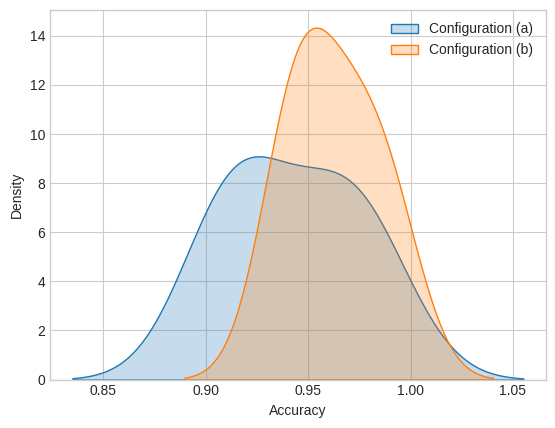

In [228]:
import seaborn as sns

ax = sns.kdeplot(acc_a, label="Configuration (a)", fill=True)
sns.kdeplot(acc_b, ax=ax, label="Configuration (b)", fill=True)

ax.set_xlabel("Accuracy")
ax.legend()
# ax.set_xlim(0.8, 1)

plt.savefig(FIG_FOLDER / "q1c_kde.png", dpi=100)

In [161]:
acc_a, acc_b

([0.92, 0.91, 0.98, 0.96], [0.95, 0.94, 0.99, 0.97])

In [229]:
from math import factorial

factorial(8)

40320

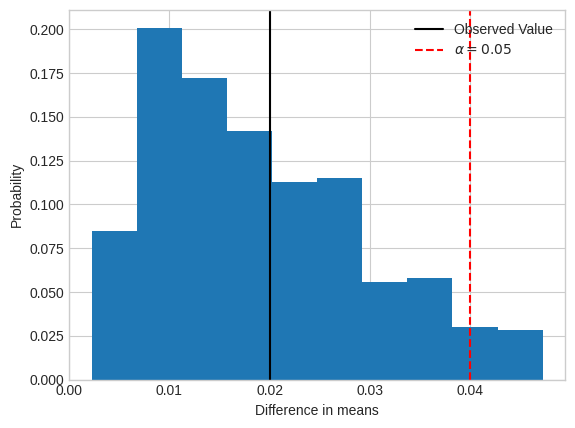

In [292]:
plt.style.use("seaborn-v0_8-whitegrid")

test_statistics = abs(mu - mu_b)

data = np.concat([acc_a, acc_b])
# tests = []

# for _ in range(100_000):
#     np.random.shuffle(data)
#     a, b = data[:4], data[4:]
#     tests.append(abs(np.mean(a) - np.mean(b)))

counts, edges = np.histogram(tests, bins=10)

alpha = np.percentile(tests, 95) 
plt.bar(edges[1:], counts/sum(counts), width=(edges[0]-edges[1])) 

# plt.plot(edges[1:], np.cumsum(counts/sum(counts)))

plt.axvline(test_statistics, c="k", label="Observed Value")
plt.axvline(alpha, c="r", ls="--", label=r"$\alpha = 0.05$")

plt.ylabel("Probability")
plt.xlabel("Difference in means")
plt.legend()

plt.savefig(FIG_FOLDER / "q1c_test.png", dpi=100)

In [254]:
edges[1:].shape, counts.shape

((20,), (20,))

In [287]:
test_statistics

0.019999999999999907

In [288]:
tests = np.array(tests)

p_value = (sum(tests >= test_statistics) / len(tests)).item()

p_value

0.39226

Let's check the mann whitney test. 

> The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [295]:
from scipy.stats import mannwhitneyu

mannwhitneyu(acc_a, acc_b)[1]

np.float64(0.4857142857142857)